# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


In [2]:
# Dateset Information
length_of_dataset = 164
num_data_train = 150
num_data_val = 14

## Configurations

In [3]:
class TrashConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "trash"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 384
    IMAGE_MAX_DIM = 512

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)# anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 50

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = TrashConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  384
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [4]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [ ]:
class TrashDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of 
    (battery, ring-pull can) 
    """
    def load_mask(self, image_id):
        """Load instance masks for the given image.

        load instance masks and return them in the form of an
        array of binary masks of shape [height, width, instances].

        Returns:
            masks: A bool array of shape [height, width, instance count] with
                a binary mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        handler = self.image_info[image_id]["handler"]
        mask = np.zeros([handler.height, handler.width, len(handler.object)], dtype=np.uint8)
        class_ids = np.zeros([len(handler.object)], dtype = np.uint8)
        info = self.image_info[image_id]
        handler = info["handler"]
        for i in range(len(handler.object)):
            for basic_class in self.class_info:
                if basic_class["name"] == handler.object[i].name:
                    class_ids[i] = basic_class["id"]
            im = np.zeros([handler.height, handler.width], dtype=np.uint8)
            cv2.fillPoly(im, np.array([handler.object[i].polygon]), 1)
            mask[:, :, i] += im[:, :]
        return mask, class_ids


In [ ]:
# Define training dataset
dataset_train = TrashDataset()
dataset_train.add_class("trash", 1, "battery")
dataset_train.add_class("trash", 2, "ring-pull can")

# Define validation dataset
dataset_val = TrashDataset()
dataset_val.add_class("trash", 1, "battery")
dataset_val.add_class("trash", 2, "ring-pull can")

In [ ]:
# Prepare dataset
# Parse annotation
import Annotation_parser
import glob
num_anno_image = 0
print("parsing information...")
for i, file_name in enumerate(glob.glob(r"./trash_mask/*.xml")):
    image_path = None
    try:
        handler = Annotation_parser.parse_annotation_info(file_name)
        image_path = "./trash_image/" + handler.file_name
    except Exception:
        print("image %s is not annotated"%file_name)
        continue
    else:
        num_anno_image+=1
    if i < num_data_train:
        print("\tdataset_train add image: %s"%image_path)
        dataset_train.add_image("trash", image_id = i, path = image_path, handler = handler)
    else:
        print("\tdataset_validation add image: %s"%image_path)
        dataset_val.add_image("trash", image_id = i - num_data_train, path = image_path, handler = handler)
        
print("information parsering finish:totally get %d image with masks"%num_anno_image)
    

parsing information...
	dataset_train add image: ./trash_image/2019_000000.jpg
	dataset_train add image: ./trash_image/2019_000001.jpg
	dataset_train add image: ./trash_image/2019_000002.jpg
	dataset_train add image: ./trash_image/2019_000003.jpg
	dataset_train add image: ./trash_image/2019_000004.jpg
	dataset_train add image: ./trash_image/2019_000005.jpg
	dataset_train add image: ./trash_image/2019_000006.jpg
	dataset_train add image: ./trash_image/2019_000007.jpg
	dataset_train add image: ./trash_image/2019_000008.jpg
	dataset_train add image: ./trash_image/2019_000009.jpg
	dataset_train add image: ./trash_image/2019_000010.jpg
	dataset_train add image: ./trash_image/2019_000011.jpg
	dataset_train add image: ./trash_image/2019_000012.jpg
	dataset_train add image: ./trash_image/2019_000013.jpg
	dataset_train add image: ./trash_image/2019_000014.jpg
	dataset_train add image: ./trash_image/2019_000015.jpg
	dataset_train add image: ./trash_image/2019_000016.jpg
	dataset_train add image:

image ./trash_mask\2019_000160.xml is not annotated
image ./trash_mask\2019_000161.xml is not annotated
image ./trash_mask\2019_000162.xml is not annotated
image ./trash_mask\2019_000163.xml is not annotated
image ./trash_mask\2019_000164.xml is not annotated
image ./trash_mask\2019_000165.xml is not annotated
image ./trash_mask\2019_000166.xml is not annotated
image ./trash_mask\2019_000167.xml is not annotated
image ./trash_mask\2019_000168.xml is not annotated
image ./trash_mask\2019_000169.xml is not annotated
image ./trash_mask\2019_000170.xml is not annotated
image ./trash_mask\2019_000171.xml is not annotated
image ./trash_mask\2019_000172.xml is not annotated
image ./trash_mask\2019_000173.xml is not annotated
image ./trash_mask\2019_000174.xml is not annotated
image ./trash_mask\2019_000175.xml is not annotated
image ./trash_mask\2019_000176.xml is not annotated
image ./trash_mask\2019_000177.xml is not annotated
image ./trash_mask\2019_000178.xml is not annotated
image ./tras

In [ ]:
# Prepare training dataset
dataset_train.prepare()

# Prepare validation dataset
dataset_val.prepare()

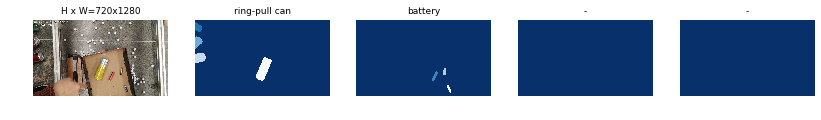

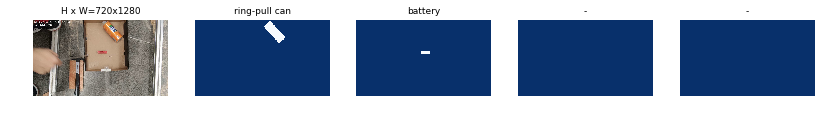

In [ ]:
# Load and display train dataset
image_ids = np.random.choice(dataset_train.image_ids, 2)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [ ]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

Re-starting from epoch 35


## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=5, 
            layers='heads')


Starting at epoch 35. LR=0.001

Checkpoint Path: C:\Users\86134\Desktop\Mask_RCNN\logs\trash20190125T1133\mask_rcnn_trash_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)


C:\Users\86134\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=60, 
            layers="all")


Starting at epoch 35. LR=0.0001

Checkpoint Path: C:\Users\86134\Desktop\Mask_RCNN\logs\trash20190125T1133\mask_rcnn_trash_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)

50/50 [==============================] - 6799s 136s/step - loss: 0.2083 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0510 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.0226 - mrcnn_mask_loss: 0.0998 - val_loss: 0.8276 - val_rpn_class_loss: 0.0106 - val_rpn_bbox_loss: 0.4497 - val_mrcnn_class_loss: 0.0593 - val_mrcnn_bbox_loss: 0.1347 - val_mrcnn_mask_loss: 0.1732
Epoch 37/60
50/50 [==============================] - 6656s 133s/step - loss: 0.2011 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0462 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.0215 - mrcnn_mask_loss: 0.0984 - val_loss: 0.8786 - val_rpn_class_loss: 0.0108 - val_rpn_bbox_loss: 0.4600 - val_mrcnn_class_loss: 0.0936 - val_mrcnn_bbox_loss: 0.1471 - val_mrcnn_mask_loss: 0.1671
Epoch 38/60
50/50 [==============================] - 6591s 132s/step - loss: 0.1939 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0397 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.0206 - mrcnn_mask_loss: 0.0982 - val_loss: 0.8106 - val_rpn_class_loss: 0

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_trash.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [ ]:
class InferenceConfig(TrashConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [ ]:
results = model.detect([original_image], verbose=1)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))